# Import Modules

In [1]:
import matplotlib.pyplot as plt
from PIL import Image #PIL may crach Colab for big data volume in my practice, suitable for trial data
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray
from tqdm import tqdm

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, Reshape, MaxPooling2D, CuDNNLSTM, Embedding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss

from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten

Using TensorFlow backend.


# Data Preparation

In [2]:
# cd '/content/drive/My Drive/SemEval_2020/memotion_analysis_training_data'
cd '/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata'

/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata


## Read CSV Data

In [3]:
PATH_CSV = "data1.csv"
PATH_IMG = "./Meme_images/"
trainX=[]
data = pd.read_csv(PATH_CSV,usecols=[0,2,8,9]) # header=None 
data.columns = ['Image_name', 'OCR_extracted_text', 'Overall_Sentiment','classes']
data.shape

(914, 4)

In [0]:
data['Overall_Sentiment'].value_counts()

positive           407
neutral            277
very_positive      149
negative            50
very_negative       20
image_and_text       8
text                 2
image                1
Name: Overall_Sentiment, dtype: int64

In [4]:
#delete wrong data
data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
data['Overall_Sentiment'].value_counts()

positive         407
neutral          277
very_positive    149
negative          50
very_negative     20
Name: Overall_Sentiment, dtype: int64

In [5]:
data.shape

(903, 4)

## Read Image data

In [0]:
#use pillow, use the same data for missing channels in error image

size = 128, 128
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  if(os.path.isfile(PATH_IMG + img_name)):
    image = Image.open(PATH_IMG + img_name)
    img = asarray(image.resize(size))
    if img.ndim != 3:
      img = np.dstack([img, img, img])
      error.append(img_name)
    X.append(img)  # storing each image in array X
  else:
    error.append(img_name)
X = np.array(X)    # converting list to array
print(error)

In [0]:
# use cv2 to import image, which is quciker than pillow
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      error.append(img_name)
  else:
    error.append(img_name)
#   print(img.shape, img_name)
print(error)

X = np.array(X)/255   # converting list to array
# width, height, channels = X.shape[1:]

100%|██████████| 903/903 [07:12<00:00,  2.64it/s]

[]


In [0]:
data = data[~data['Image_name'].isin(error)] # delete data of error images

Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])

width, height, channels = X.shape[1], X.shape[2], X.shape[3]
data.shape,X.shape,Y.shape

((903, 3), (903, 128, 128, 3), (903, 5))

## Or import processed img data

In [0]:
# Import pre-processed image data
import pickle 

# pickle_out = open("/content/drive/My Drive/SemEval_2020/pickles/trial_train_128_128.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/pickles/trial_trainY.pickle", "wb")
# pickle.dump(Y, pickle_out)
# pickle_out.close()

X = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/trial_train_128_128.pickle", "rb"))
Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/trial_trainY.pickle", "rb"))
width, height, channels = X.shape[1:]

In [7]:
data['classes'].value_counts().index

Index(['image_and_text ', 'image', 'text', 'image_and_text  '], dtype='object')

In [0]:
data.replace('image_and_text ', 'image_and_text',inplace=True)
data.replace('image_and_text  ', 'image_and_text',inplace=True)

In [9]:
data['classes'].value_counts()

image_and_text    718
image             138
text               47
Name: classes, dtype: int64

In [10]:
Y_class = to_categorical(data['classes'].factorize()[0])
Y_class

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [12]:
Y_class.shape

(903, 3)

In [13]:
trainYcate3 = [np.argmax(i) for i in Y_class]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainYcate3),
                                                 trainYcate3)
class_weights

array([0.41922006, 2.18115942, 6.40425532])

# Modelling

## Image Data + CNN

In [0]:
# Train-test Split
np.random.RandomState(0)
np.random.seed(0)
tf.set_random_seed(0)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (722, 200, 200, 3) (722, 5)
Test ((181, 200, 200, 3), (181, 5))
Train 0.0 1.0 0.48231554962613044 0.33994291592404074
Test 0.0 1.0 0.46073626656555744 0.33864667521435543


In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize

# prepare an iterators to scale images
train_iterator = datagen.flow(trainX, trainY, batch_size=64)
test_iterator = datagen.flow(testX, testY, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batches train=12, test=3
Batch shape=(64, 200, 200, 3), min=0.000, max=1.000


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


### Model 1 - 2Conv
Conv64-Conv64-Dense64 (image only)

In [0]:
# define inital model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))


model.add(Dense(3, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 57600)            

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')

# # fit model with generator

# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=50)

# # evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

results = model.fit(X, Y_class,
         epochs=5,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
#          validation_data=(testX,testY),
         callbacks=[es],
        class_weight=class_weights
         )


Train on 722 samples, validate on 181 samples
Epoch 1/5
722/722 [==============================] - 1s 2ms/sample - loss: 1.9209 - acc: 0.7202 - val_loss: 0.8666 - val_acc: 0.7901
Epoch 2/5
722/722 [==============================] - 1s 1ms/sample - loss: 0.7237 - acc: 0.7964 - val_loss: 0.6969 - val_acc: 0.7901
Epoch 3/5
722/722 [==============================] - 1s 1ms/sample - loss: 0.6576 - acc: 0.7964 - val_loss: 0.6820 - val_acc: 0.7901
Epoch 4/5
722/722 [==============================] - 1s 1ms/sample - loss: 0.6481 - acc: 0.7964 - val_loss: 0.6321 - val_acc: 0.7901
Epoch 5/5
722/722 [==============================] - 1s 1ms/sample - loss: 0.6311 - acc: 0.7964 - val_loss: 0.6279 - val_acc: 0.7901


In [0]:
model.save("./img_text_clr.model")

In [14]:
from tensorflow.keras.models import load_model
img_text_model = load_model('/content/drive/My Drive/SemEval_2020/img_text_clr.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
temp = img_text_model.predict(X)
pd.Series([np.argmax(i) for i in temp]).value_counts()

0    903
dtype: int64

In [16]:
img_text_model.evaluate(X, Y_class)

903/903 [==============================] - 6s 7ms/sample - loss: 0.6132 - acc: 0.7951


[0.6132243282903205, 0.79512733]

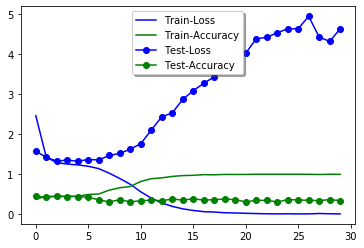

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

### Model 2 - 3Conv
Conv32-Conv64-Conv128-Dense128 (image only)

In [0]:
# 3 Conv model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 32768)           

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(trainX, trainY,
         epochs=30,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
#          callbacks=[es]
         )

Train on 722 samples, validate on 181 samples
Epoch 1/30
722/722 [==============================] - 1s 2ms/sample - loss: 5.9848 - acc: 0.3476 - val_loss: 1.5540 - val_acc: 0.1657
Epoch 2/30
722/722 [==============================] - 0s 600us/sample - loss: 1.4060 - acc: 0.3670 - val_loss: 1.4022 - val_acc: 0.4586
Epoch 3/30
722/722 [==============================] - 0s 618us/sample - loss: 1.2761 - acc: 0.4806 - val_loss: 1.3213 - val_acc: 0.4475
Epoch 4/30
722/722 [==============================] - 0s 594us/sample - loss: 1.1894 - acc: 0.5000 - val_loss: 1.3364 - val_acc: 0.3536
Epoch 5/30
722/722 [==============================] - 0s 598us/sample - loss: 1.0903 - acc: 0.5900 - val_loss: 1.3640 - val_acc: 0.3757
Epoch 6/30
722/722 [==============================] - 0s 609us/sample - loss: 0.9098 - acc: 0.6828 - val_loss: 1.5106 - val_acc: 0.3536
Epoch 7/30
722/722 [==============================] - 0s 597us/sample - loss: 0.7474 - acc: 0.7119 - val_loss: 1.4884 - val_acc: 0.3702
Epoc

In [0]:
model.evaluate(testX,testY)

181/181 [==============================] - 0s 386us/sample - loss: 4.6097 - acc: 0.3591


[4.609722529985628, 0.35911602]

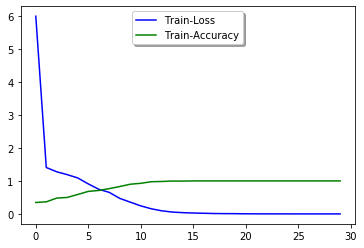

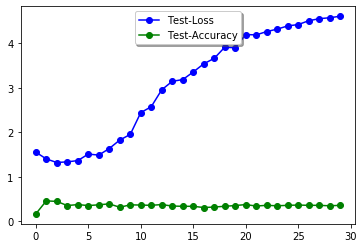

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

## Text Data + LSTM

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
t = Tokenizer()
X_text = data['OCR_extracted_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

3327


In [0]:
encoded_train = t.texts_to_sequences(X_text)
max(list(map(lambda x: len(x), encoded_train)))

190

In [0]:
max_length = 190
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[0]

array([1208,  280,   24,  182, 1209,    3,  123,   61,   45,  710,   12,
        394,   40,    6,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])
len(X_text),len(Y)

(903, 903)

In [0]:
# Train-test Split

trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (722, 190) (722, 5)
Test ((181, 190), (181, 5))
Train 0 3326 42.35010205569325 277.76395122714587
Test 0 3310 35.652428031404476 253.24945013095882


In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
results = model.fit(trainX, trainY, epochs=50, shuffle=True, validation_data=(testX,testY), batch_size=64)

Train on 722 samples, validate on 181 samples
Epoch 1/50
722/722 [==============================] - 1s 736us/sample - loss: 1.3644 - acc: 0.3920 - val_loss: 1.2771 - val_acc: 0.4530
Epoch 2/50
722/722 [==============================] - 0s 309us/sample - loss: 1.2740 - acc: 0.4474 - val_loss: 1.2773 - val_acc: 0.4530
Epoch 3/50
722/722 [==============================] - 0s 240us/sample - loss: 1.2688 - acc: 0.4501 - val_loss: 1.2659 - val_acc: 0.4586
Epoch 4/50
722/722 [==============================] - 0s 224us/sample - loss: 1.2146 - acc: 0.4751 - val_loss: 1.2645 - val_acc: 0.4586
Epoch 5/50
722/722 [==============================] - 0s 226us/sample - loss: 1.0026 - acc: 0.6385 - val_loss: 1.4148 - val_acc: 0.4199
Epoch 6/50
722/722 [==============================] - 0s 236us/sample - loss: 0.6733 - acc: 0.7632 - val_loss: 2.0249 - val_acc: 0.3978
Epoch 7/50
722/722 [==============================] - 0s 225us/sample - loss: 0.4462 - acc: 0.8476 - val_loss: 2.0886 - val_acc: 0.3591
Ep

In [0]:
model.evaluate(testX,testY)

181/181 [==============================] - 0s 285us/sample - loss: 4.7727 - acc: 0.3370


[4.772659409770649, 0.33701658]

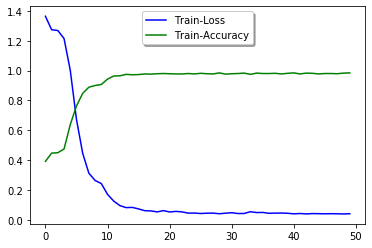

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

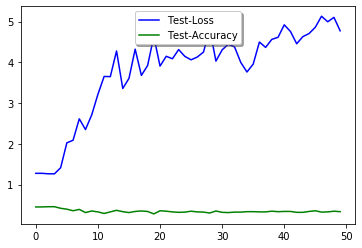

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

# Manual Test

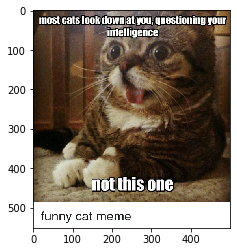

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][814]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
#prediction
temp = model.predict(X.reshape(-1,128,128,3))
temp_pre = [np.argmax(i) for i in temp]
# temp_pre

In [0]:
#Ground Truth
temp = Y
temp_truth = [np.argmax(i) for i in temp]
# temp_truth

In [0]:
print('accuracy:',accuracy_score(temp_pre, temp_truth))
print('F1:',f1_score(temp_pre, temp_truth, average='macro'))

accuracy: 0.8737541528239202
F1: 0.8620340788732481
